<a href="https://colab.research.google.com/github/st-tran/CSC413-Project/blob/main/CSC413_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC413 Project: GeoGuessr!


## A bunch of imports

In [ ]:
from typing import *
from collections import defaultdict
from PIL import Image
from IPython.display import display
from glob import glob
import re
import os
from random import shuffle
import time
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import xml.etree.ElementTree as ET
import numpy as np
 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms, models

## Visualizing stuff

In [ ]:
# Reverse normalization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def visualize_example(tup, batch_idx=0, invert=False):
  dst = Image.new("RGB", (1024, 256))
  tup = tuple(tup[batch_idx, i] for i in range(4))

  if invert: 
    tup = tuple(inv_normalize(t) for t in tup)
  dst.paste(transforms.ToPILImage()(tup[0]), (0, 0))
  dst.paste(transforms.ToPILImage()(tup[1]), (256, 0))
  dst.paste(transforms.ToPILImage()(tup[2]), (512, 0))
  dst.paste(transforms.ToPILImage()(tup[3]), (768, 0))
  display(dst)

def get_borders(states_file):
    """ From original DeepGeo paper """
    #init
    borders = []

    # get state borders  
    tree = ET.parse(states_file)
    root = tree.getroot()
    count = 0
    for child in root:
        count+=1
        stateBorder = np.empty((0,2),dtype=np.float64)
        for point in child:
            stateBorder = np.append(stateBorder,np.array([[point.attrib['lng'], point.attrib['lat']]]),axis=0)
        borders.append(stateBorder)

    return borders

def get_labels(states_file):
    """ From original DeepGeo paper """
    labels = []

    # get state borders  
    tree = ET.parse(states_file)
    root = tree.getroot()
    count = 0
    for child in root:
        labels.append(child.attrib['name'])

    return labels

def plot_data_samples():
    coords = []
    for d in glob("training/*"):
      with open(f"/content/{d}/info.txt", "r") as f:
        coords.extend([l.split(" ")[-3:-1] for l in f.readlines() if not l.startswith("/mnt") and not l.startswith("//mnt")])
    coords = [coord for coord in coords if len(coord)==2 and coord[0] and coord[1]]
    borders = get_borders("Canada.kml")
    labels = get_labels("Canada.kml")
    
    bord_arr = np.concatenate(borders).astype(float)
    fig, ax = plt.subplots()
    lines = LineCollection([bord_arr])
    ax.add_collection(lines)
    coords_arr = np.array(coords).astype(float)
    ax.scatter(coords_arr[:,1], coords_arr[:,0], s=1)
    ax.autoscale()
    plt.show()
    

## Load in the data

In [ ]:
# 1k Canada dataset
!gdown --id 1QSVxo_GpPQ5gHVh6hkQCEktt6jGX3AoO

# Min 3.5k Canada dataset
# !gdown --id 1JjbMa-n_jb0X60KNk4h12ePjynTwMgwO

# Canadian provinces
!gdown --id 1SMxaLVYSDKS3AT3T8f_BgkWYBzWnrCqM
!mkdir /content/training

Downloading...
From: https://drive.google.com/uc?id=1QSVxo_GpPQ5gHVh6hkQCEktt6jGX3AoO
To: /content/1kimages090180270.tar.gz
420MB [00:01, 230MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SMxaLVYSDKS3AT3T8f_BgkWYBzWnrCqM
To: /content/Canada.kml
100% 38.3k/38.3k [00:00<00:00, 33.7MB/s]
mkdir: cannot create directory ‘/content/training’: File exists


In [ ]:
%%capture
!tar -xzvf 1kimages090180270.tar.gz -C /content/training
# !tar -xzvf min3kimages.tar.gz -C /content/training
!for d in /content/training/images*; do mv "${d}" "/content/training/`basename "${d}" | sed -e 's/images//g' | sed -e 's/\s//g'`"; done
!rm -rf /content/1kimages090180270.tar.gz
# !rm -rf min3kimages.tar.gz

In [ ]:
data = defaultdict(list)

def get_image_ids(province: str) -> List[str]:
  images = glob(f"/content/training/{province}/*.jpg")
  ids_no_angle = [re.sub('_[\\d]*.jpg', '', f) for f in images]
  return ids_no_angle 

def stitch_images_and_save(image_base_path: str) -> None:
  img = Image.new("RGB", (512, 512))
  img_0 = Image.open(f"{image_base_path}_0.jpg")
  img_90 = Image.open(f"{image_base_path}_90.jpg")
  img_180 = Image.open(f"{image_base_path}_180.jpg")
  img_270 = Image.open(f"{image_base_path}_270.jpg")
  img.paste(img_0, (0, 0))
  img.paste(img_90, (256, 0))
  img.paste(img_180, (0, 256))
  img.paste(img_270, (256, 256))

  new_name = f"{image_base_path}_stitched.jpg"
  img.save(new_name)
  data[image_base_path.split("/")[-2]].append(new_name)

## A custom dataset

In [ ]:
preprocess =  transforms.Compose([
                    transforms.Resize(224),
                    #transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])
class GeoDataset(Dataset):
  """
  Holds a bunch of (N, E, S, W) quadruplets of examples along with the corresponding province labels.

  # Todo: maybe add transform?
  """
  def __init__(self, index_file, transform=None, shuf=False):
    self.index_file = index_file
    self.transform = transform

    self.labels = {k: i for i, k in enumerate(index_file.keys())}

    # Data has (N, E, S, W, province)
    self.data = []
    for prov, tups in index_file.items():
      for tup in tups:
        self.data.append((*tup, prov))
    if shuf:
      shuffle(self.data)

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, idx):
    """
    Returns: 
      (N, E, S, W) images, province
    tuple
    """
    tup = self.data[idx]
    images = torch.cat(tuple(preprocess(Image.open(t)).unsqueeze(0) for t in tup[:-1]), 0) 
    return (images, self.labels[tup[-1]])


In [ ]:
index_files = defaultdict(list)

for province in glob("/content/training/*"):
  name = os.path.basename(province)
  for image in get_image_ids(name):
    # stitch_images_and_save(image)
    index_files[name].append(tuple(f"{image}_{angle}.jpg" for angle in ("0", "90", "180", "270")))

In [ ]:
dataset = GeoDataset(index_files)
length = len(dataset)

val_frac = test_frac = 0.1
train_len = int(train_frac*length)
val_len = test_len = int(val_frac*length)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_len, val_len, test_len])

#train_set = torch.utils.data.Subset(dataset, list(range(0, int(train_frac*length))))
#val_set = torch.utils.data.Subset(dataset, list(range(len(train_set), len(train_set)+int(val_frac*length)+1)))
#test_set = torch.utils.data.Subset(dataset, list(range(len(train_set)+len(val_set), len(train_set)+len(val_set) + int(test_frac*length)+1)))
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2, prefetch_factor=8)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=2, prefetch_factor=8)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=2, prefetch_factor=8)

In [ ]:
images, labels = next(iter(test_loader))

# What the data looks like
We have in the top image the unnormalized image. 

The image below that is the same image, but with normalization as a preprocessing step before adding it to the model.

The third image contains a scatterplot of where street view data samples were collected across Canada. Because most upper parts of Canada are sparsely populated, not much data was collected; the Thunder Bay area in Ontario, for example, is one of the northmost areas that have data...most of the data in Ontario is in the GTA region.

Note: the map looks very crude to simplify the data collection and classification process because it didn't really matter how fine the details were on the borders since street view doesn't gather images right by the oceanside.

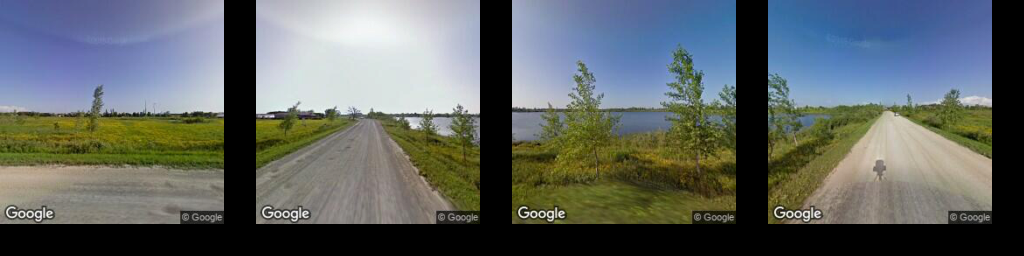

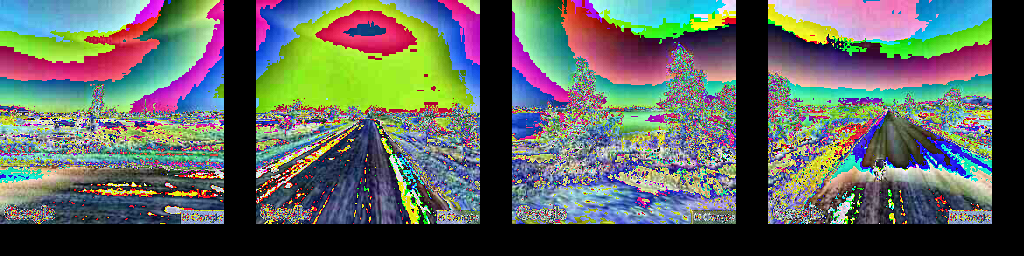

ValueError: ignored

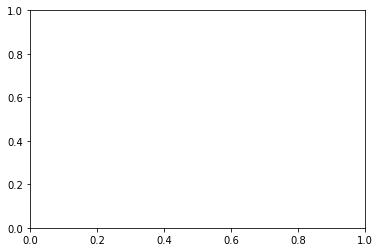

In [108]:
visualize_example(images, 10, True)
visualize_example(images, 10, False)
plot_data_samples()

## Code to actually do the training logic

In [ ]:
class AttrDict(dict):
  def __init__(self, *args, **kwargs):
    super(AttrDict, self).__init__(*args, **kwargs)
    self.__dict__ = self


def compute_loss(criterion, outputs, labels, batch_size, num_colours):
  """ Copied from A2 """
  loss_out = outputs.transpose(1, 3).contiguous().view([-1, num_colors])
  loss_lab = labels.transpose(1, 3).contiguous().view([-1])
  return criterion(loss_out, loss_lab)

def train(args, cnn=None):
  save_dir = f"/outputs/{args.experiment_name}"
  num_labels = len(dataset.labels)
  num_in_channels = 3

  if cnn is None:
    Net = globals()[args.model]
    cnn = Net(args.kernel, args.num_filters, num_colours, num_in_channels)

  # Loss function
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

  print("Beginning training...")
  if args.gpu:
    cnn.cuda()
  start = time.time()

  train_losses = []
  valid_losses = []
  valid_accs = []
  for epoch in range(args.epochs):
    # Train the model
    cnn.train()
    losses = []
    for i, (images, labels) in enumerate(dataset):
      # Forward + Backward + Optimize
      optimizer.zero_grad()
      outputs = cnn(images)

      loss = compute_loss(
          criterion, outputs, labels, batch_size=args.batch_size, num_colours=num_colours
      )

      loss.backward()
      optimizer.step()
      losses.append(loss.data.item())

      # plot training images
      avg_loss = np.mean(losses)
      train_losses.append(avg_loss)
      time_elapsed = time.time() - start
      print(
          "Epoch [%d/%d], Loss: %.4f, Time (s): %d"
          % (epoch + 1, args.epochs, avg_loss, time_elapsed)
      )

      # Evaluate the model
      cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
      val_loss, val_acc = run_validation_step(
          cnn,
          criterion,
          test_grey,
          test_rgb_cat,
          args.batch_size,
          colours,
          save_dir + "/test_%d.png" % epoch,
          args.visualize,
          args.downsize_input,
      )

      time_elapsed = time.time() - start
      valid_losses.append(val_loss)
      valid_accs.append(val_acc)
      print(
          "Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f"
          % (epoch + 1, args.epochs, val_loss, val_acc, time_elapsed)
      )

  # Plot training curve
  plt.figure()
  plt.plot(train_losses, "ro-", label="Train")
  plt.plot(valid_losses, "go-", label="Validation")
  plt.legend()
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.savefig(save_dir + "/training_curve.png")

  if args.checkpoint:
      print("Saving model...")
      torch.save(cnn.state_dict(), args.checkpoint)

  return cnn


In [ ]:
!pip install torch_tb_profiler


     |████████████████████████████████| 778kB 8.4MB/s 


## 18-Layer Resnet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

#with torch.profiler.profile(
#    with_stack=True, profile_memory=True,
#    schedule=torch.profiler.schedule(
#        wait=1,
#        warmup=1,
#        active=4,
#        repeat=1),
#    on_trace_ready=torch.profiler.tensorboard_trace_handler,
#) as profiler:
for epoch in range(epochs):
      for i, data in enumerate(train_loader):
          inputs, labels = data
          steps += 1
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()

          n_logps = model.forward(inputs[:,0,...])
          n_loss = criterion(n_logps, labels)
          n_loss.backward()

          e_logps = model.forward(inputs[:,1,...])
          e_loss = criterion(e_logps, labels)
          e_loss.backward()

          s_logps = model.forward(inputs[:,2,...])
          s_loss = criterion(s_logps, labels)
          s_loss.backward()

          w_logps = model.forward(inputs[:,3,...])
          w_loss = criterion(w_logps, labels)
          w_loss.backward()

          loss = n_loss + e_loss + s_loss + w_loss

          optimizer.step()
          profiler.step()
          running_loss += loss.item()
          
          if steps % print_every == 0:
              test_loss = 0
              accuracy = 0
              model.eval()
              with torch.no_grad():
                  for inputs, labels in test_loader:
                      inputs, labels = inputs.to(device), labels.to(device)

                      n_logps = model.forward(inputs[:,0,...])
                      n_batch_loss = criterion(n_logps, labels)
                      test_loss += n_batch_loss.item()

                      e_logps = model.forward(inputs[:,1,...])
                      e_batch_loss = criterion(e_logps, labels)
                      test_loss += e_batch_loss.item()

                      s_logps = model.forward(inputs[:,2,...])
                      s_batch_loss = criterion(s_logps, labels)
                      test_loss += s_batch_loss.item()

                      w_logps = model.forward(inputs[:,3,...])
                      w_batch_loss = criterion(w_logps, labels)
                      test_loss += w_batch_loss.item()

                      logps = (n_logps + e_logps + s_logps + w_logps)/4
                      
                      ps = torch.exp(logps)
                      top_p, top_class = ps.topk(1, dim=1)
                      equals = top_class == labels.view(*top_class.shape)
                      accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
              train_losses.append(running_loss/len(train_loader))
              test_losses.append(test_loss/len(test_loader))                    
              print(f"Epoch {epoch+1}/{epochs}.. "
                    f"Train loss: {running_loss/print_every:.3f}.. "
                    f"Test loss: {test_loss/len(test_loader):.3f}.. "
                    f"Test accuracy: {accuracy/len(test_loader):.3f}")
              running_loss = 0
              model.train()
            

Epoch 1/1.. Train loss: 10.058.. Test loss: 9.416.. Test accuracy: 0.095
Epoch 1/1.. Train loss: 9.329.. Test loss: 9.152.. Test accuracy: 0.127
Epoch 1/1.. Train loss: 9.101.. Test loss: 9.073.. Test accuracy: 0.106
Epoch 1/1.. Train loss: 9.157.. Test loss: 8.892.. Test accuracy: 0.192
Epoch 1/1.. Train loss: 9.052.. Test loss: 8.841.. Test accuracy: 0.160
Epoch 1/1.. Train loss: 8.936.. Test loss: 8.831.. Test accuracy: 0.207
Epoch 1/1.. Train loss: 8.770.. Test loss: 8.668.. Test accuracy: 0.234
Epoch 1/1.. Train loss: 8.889.. Test loss: 8.800.. Test accuracy: 0.167
Epoch 1/1.. Train loss: 8.762.. Test loss: 8.572.. Test accuracy: 0.221
Epoch 1/1.. Train loss: 8.644.. Test loss: 8.442.. Test accuracy: 0.232
Epoch 1/1.. Train loss: 8.664.. Test loss: 8.374.. Test accuracy: 0.284
Epoch 1/1.. Train loss: 8.502.. Test loss: 8.239.. Test accuracy: 0.295
Epoch 1/1.. Train loss: 8.540.. Test loss: 8.190.. Test accuracy: 0.289
Epoch 1/1.. Train loss: 8.434.. Test loss: 8.195.. Test accurac

## Predictions from pretrained guy

In [ ]:
pretrained = models.resnet18(pretrained=False)
pretrained.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 10),
                                 nn.LogSoftmax(dim=1))
pretrained.load_state_dict(torch.load("resnetsmalldataset"))
pretrained.eval()
images, labels = next(iter(test_loader))

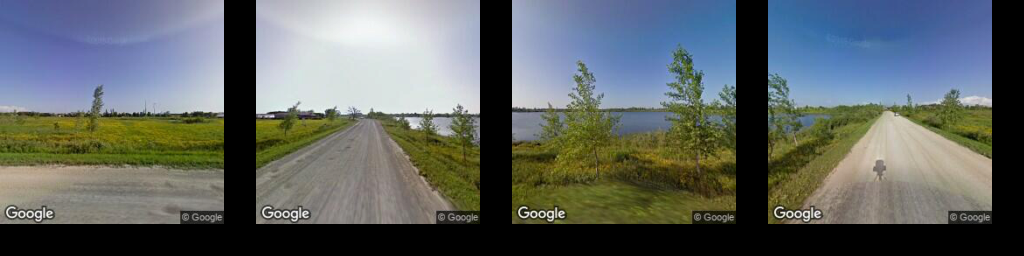

Actual province: Manitoba
North prediction: Saskatchewan
East prediction: Saskatchewan
South prediction: NewBrunswick
West prediction: Manitoba
Combined prediction: Saskatchewan


In [ ]:
visualize_example(images, 10, True)
smax = pretrained.forward(images[10])
comb = smax.mean(axis=0)
preds = smax.argmax(axis=1)
comb_preds = comb.argmax()
real_labels = dict((v, k) for k, v in dataset.labels.items())
print(f"Actual province: {real_labels[labels[10].item()]}")
print(f"North prediction: {real_labels[preds[0].item()]}")
print(f"East prediction: {real_labels[preds[1].item()]}")
print(f"South prediction: {real_labels[preds[2].item()]}")
print(f"West prediction: {real_labels[preds[3].item()]}")
print(f"Combined prediction: {real_labels[comb_preds.item()]}")

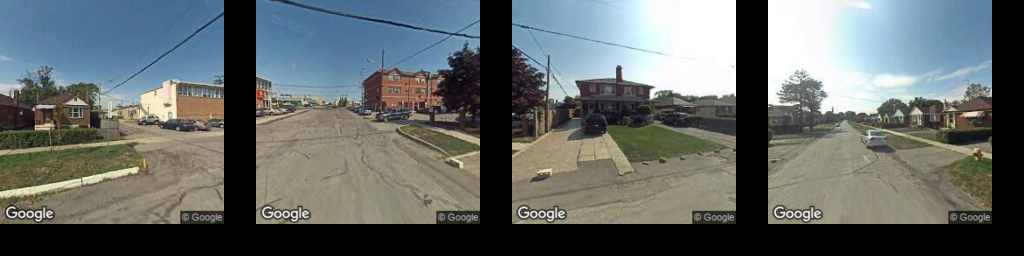

Actual province: Ontario
North prediction: Ontario
East prediction: Ontario
South prediction: Ontario
West prediction: Alberta
Combined prediction: Ontario


In [ ]:
visualize_example(images, 5, True)
smax = pretrained.forward(images[5])
comb = smax.mean(axis=0)
preds = smax.argmax(axis=1)
comb_preds = comb.argmax()
real_labels = dict((v, k) for k, v in dataset.labels.items())
print(f"Actual province: {real_labels[labels[5].item()]}")
print(f"North prediction: {real_labels[preds[0].item()]}")
print(f"East prediction: {real_labels[preds[1].item()]}")
print(f"South prediction: {real_labels[preds[2].item()]}")
print(f"West prediction: {real_labels[preds[3].item()]}")
print(f"Combined prediction: {real_labels[comb_preds.item()]}")


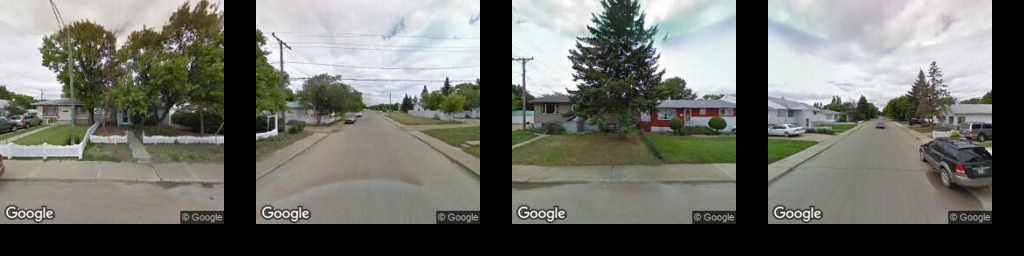

Actual province: Saskatchewan
North prediction: Saskatchewan
East prediction: Alberta
South prediction: Alberta
West prediction: Alberta
Combined prediction: Alberta


In [ ]:
visualize_example(images, 20, True)
smax = pretrained.forward(images[20])
comb = smax.mean(axis=0)
preds = smax.argmax(axis=1)
comb_preds = comb.argmax()
real_labels = dict((v, k) for k, v in dataset.labels.items())
print(f"Actual province: {real_labels[labels[20].item()]}")
print(f"North prediction: {real_labels[preds[0].item()]}")
print(f"East prediction: {real_labels[preds[1].item()]}")
print(f"South prediction: {real_labels[preds[2].item()]}")
print(f"West prediction: {real_labels[preds[3].item()]}")
print(f"Combined prediction: {real_labels[comb_preds.item()]}")
